In [133]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
warnings.filterwarnings('ignore')
from scipy import stats
import xgboost as xgb
import seaborn as sns

In [2]:
'''https://www.kaggle.com/ntnu-testimon/paysim1'''

'https://www.kaggle.com/ntnu-testimon/paysim1'

In [3]:
data = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

In [4]:
display(data.head())
data.shape

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


(6362620, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
for column_name in data.columns.values:
    data_sizes = data.groupby(column_name).size()
    total_count = data[column_name].shape
    unique_values = list(data_sizes.index)
    print('Column: %s, Total count: %d, Unique categories count: %d' %(column_name, total_count[0], len(unique_values)))

Column: step, Total count: 6362620, Unique categories count: 743
Column: type, Total count: 6362620, Unique categories count: 5
Column: amount, Total count: 6362620, Unique categories count: 5316900
Column: nameOrig, Total count: 6362620, Unique categories count: 6353307
Column: oldbalanceOrg, Total count: 6362620, Unique categories count: 1845844
Column: newbalanceOrig, Total count: 6362620, Unique categories count: 2682586
Column: nameDest, Total count: 6362620, Unique categories count: 2722362
Column: oldbalanceDest, Total count: 6362620, Unique categories count: 3614697
Column: newbalanceDest, Total count: 6362620, Unique categories count: 3555499
Column: isFraud, Total count: 6362620, Unique categories count: 2
Column: isFlaggedFraud, Total count: 6362620, Unique categories count: 2


In [7]:
def show_ratio(data, column):
    data_sizes = data.groupby(column).size()
    total_count = data[column].shape
    unique_values = list(data_sizes.index)
    print('Total count: %d, Unique categories count: %d' %(total_count[0], len(unique_values)))
    sizes_p = []
    for s in data_sizes:
        sizes_p.append(s*100/total_count[0])
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = plt.pie(sizes_p, labels=unique_values, autopct='%.5f%%', shadow=False)
    legend_values = []
    for (i, uv) in enumerate(unique_values):
        legend_values.append('%s : %.5f%%, abs value: %d' %(uv, sizes_p[i], data_sizes[uv]))
    ax.legend(wedges, legend_values,
              title="Unique Values",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Unique Values on column: " + column)
    plt.show()

Total count: 6362620, Unique categories count: 5


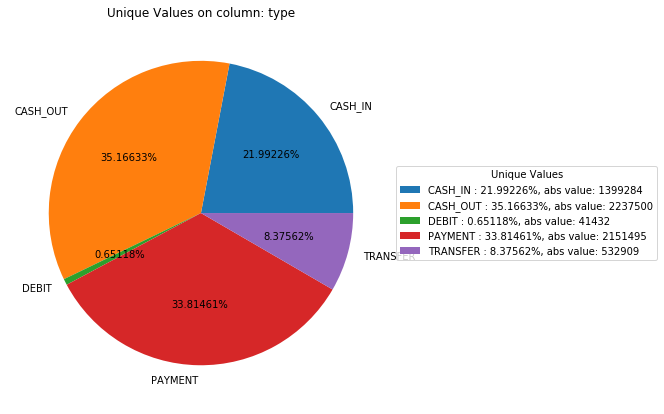

Total count: 6362620, Unique categories count: 2


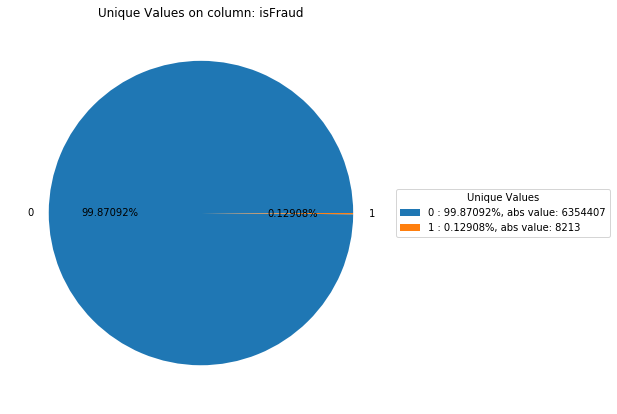

Total count: 6362620, Unique categories count: 2


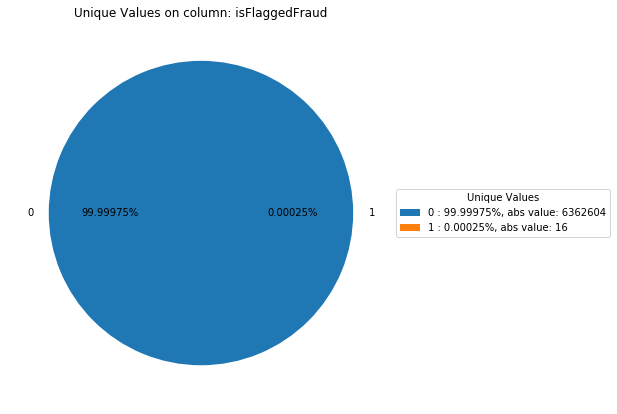

In [8]:
show_ratio(data, 'type')
show_ratio(data, 'isFraud')
show_ratio(data, 'isFlaggedFraud')

In [4]:
df = data.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [4]:
df_cot = data.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'amount', 'oldbalanceOrg',
                'newbalanceOrig' , 'oldbalanceDest', 'newbalanceDest'], axis=1)
df_cot.head()

,type,isFraud
0,PAYMENT,0
1,PAYMENT,0
2,TRANSFER,1
3,CASH_OUT,1
4,PAYMENT,0


In [5]:
df_cont = data.drop(['step', 'nameOrig', 'nameDest', 'type', 'isFraud', 'isFlaggedFraud'], axis=1)
df_cont.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.0,160296.36,0.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0
2,181.00,181.0,0.00,0.0,0.0
3,181.00,181.0,0.00,21182.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0


In [5]:
def categorize_columns(df, columns=[], used_uniq=3):
    df = df.copy()
    for column in columns:
        uniq = df.groupby(column).size().sort_values()
        mask = [df[column]==uniq_value for uniq_value in list(uniq.tail(used_uniq).index)]
        df[column] = np.where(np.logical_or.reduce((mask)), df[column], 'OTHER')
    return  df

def prep_data(data):
    columns = ['type']
    prep_data = categorize_columns(data, columns, used_uniq=6)
    prep_data = pd.get_dummies(prep_data, columns=columns, prefix = columns)
    scaler = StandardScaler()
    prep_data[['amount', 'oldbalanceOrg', 'newbalanceOrig' , 'oldbalanceDest', 'newbalanceDest']] =\
        scaler.fit_transform(prep_data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
    return prep_data

In [ ]:
df_cot = prep_data(df_cot)

In [6]:
df = prep_data(df)

In [19]:
print(df.shape)
df.head()

(6362620, 11)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0,0,1,0
1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0,0,1,0
2,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,1,0,0,0,0,1
3,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,0,1,0,0,0
4,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0,0,1,0


In [70]:
df = df[df['isFraud']==0]
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0,0,1,0
1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0,0,1,0
4,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0,0,1,0
5,-0.284908,-0.270068,-0.276696,-0.323814,-0.333411,0,0,0,0,1,0
6,-0.286084,-0.225289,-0.232221,-0.323814,-0.333411,0,0,0,0,1,0


In [8]:
print(df_cot.shape)
df_cot.head()

(6362620, 6)


,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,1,0,0,0,0,1
3,1,0,1,0,0,0
4,0,0,0,0,1,0


In [9]:
scaler = StandardScaler()
df_cont[['amount', 'oldbalanceOrg', 'newbalanceOrig' , 'oldbalanceDest', 'newbalanceDest']] =\
    scaler.fit_transform(df_cont[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

In [10]:
print(df_cont.shape)
df_cont.head()

(6362620, 5)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411
1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411
2,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411
3,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411
4,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411


In [8]:
def fetch_batch(x, y, batch_index, batch_size):
    start = batch_index*batch_size
    end = batch_index*batch_size+batch_size
    x_batch = x[start:end]
    if y is not None:
        y_batch = y[start:end]
        return x_batch, y_batch
    else:
        return x_batch

In [54]:
class Net(nn.Module):
    def __init__(self, input_dim=10, out_dim=10):
        super(Net, self).__init__()
        self.h1 = nn.Linear(input_dim, 15)
        self.h2 = nn.Linear(15, 10)
        self.h3 = nn.Linear(10, 15)
        self.logit = nn.Linear(15, out_dim)

    def forward(self, x):
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        x = torch.relu(self.h3(x))
        x = self.logit(x)
        return x
    
    def inner(self, x):
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        return x

In [55]:
net = Net()
print(net)

Net(
  (h1): Linear(in_features=10, out_features=15, bias=True)
  (h2): Linear(in_features=15, out_features=10, bias=True)
  (h3): Linear(in_features=10, out_features=15, bias=True)
  (logit): Linear(in_features=15, out_features=10, bias=True)
)


In [50]:
train_data = df.as_matrix()
train_data = train_data.astype(np.float32)
print(train_data[:5])
np.random.shuffle(train_data)
print(train_data[:5])

[[-0.2815599  -0.22981004 -0.2376217  -0.3238139  -0.3334114   0.
   0.          0.          0.          1.          0.        ]
 [-0.29476726 -0.28135937 -0.2858123  -0.3238139  -0.3334114   0.
   0.          0.          0.          1.          0.        ]
 [-0.2975548  -0.2886538  -0.2924417  -0.3238139  -0.3334114   1.
   0.          0.          0.          0.          1.        ]
 [-0.2975548  -0.2886538  -0.2924417  -0.3175824  -0.3334114   1.
   0.          1.          0.          0.          0.        ]
 [-0.27853188 -0.27432916 -0.282221   -0.3238139  -0.3334114   0.
   0.          0.          0.          1.          0.        ]]
[[ 8.9021647e-05 -2.8853849e-01 -2.9244170e-01 -2.3886821e-01
  -2.0585427e-01  0.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-2.6924866e-01 -2.8855234e-01 -2.9244170e-01 -3.2381389e-01
  -3.3341140e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [-2.66226

In [51]:
target = train_data[:, 5]
train_data = train_data[:, [0,1,2,3,4,6,7,8,9,10]]
print(target[:5])
train_data[:5]

[0. 0. 0. 0. 0.]


array([[ 8.9021647e-05, -2.8853849e-01, -2.9244170e-01, -2.3886821e-01,
        -2.0585427e-01,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [-2.6924866e-01, -2.8855234e-01, -2.9244170e-01, -3.2381389e-01,
        -3.3341140e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00],
       [-2.6622671e-01, -2.8504121e-01, -2.9244170e-01, -3.2381389e-01,
        -3.3341140e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00],
       [-2.7426693e-01, -2.5636038e-01, -2.6535302e-01, -3.2381389e-01,
        -3.3341140e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00],
       [-1.8362255e-01, -2.8732702e-01, -2.9244170e-01, -2.0914447e-01,
        -2.0854864e-01,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [56]:
def train(net, x_train, epoches=5, lr=0.01):
#     y_train = x_train
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    N_EPOCHES = epoches
    BS = 10000
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    print(n_batches)
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
#         np.random.shuffle(x_train)
        y_train = x_train
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
#             print(x_train_var)
#             print(y_train_var)
#             break
            optimizer.zero_grad()
            outputs = net(x_train_var)
            loss = criterion(outputs, y_train_var)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
#             if loss.item() >= 0.05 and i > 1:
                
            if bi%100 == 0:
                sys.stdout.write('\rEpoch: %d Iter: %d train loss: %.5f'
                                 %(i, bi, loss.item()))
                sys.stdout.flush()
        test_losses.append(loss.item())
#             if loss.item() < 0.001:
#                 break
#         break
    return train_losses, test_losses

In [57]:
train_losses, test_losses = train(net, train_data)

637
Epoch: 4 Iter: 600 train loss: 0.00007

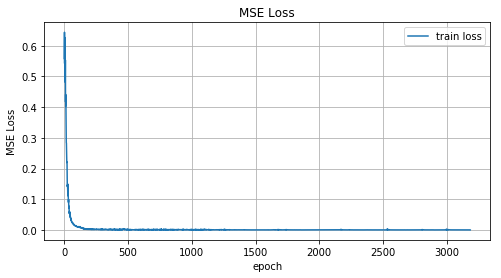

In [58]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(train_losses)), train_losses)
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss'])
plt.title('MSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

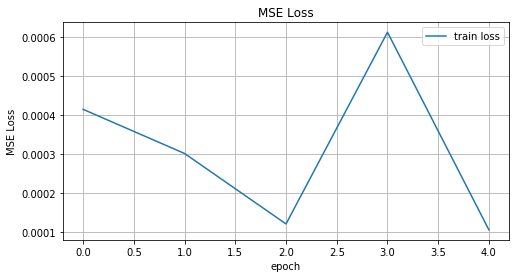

In [59]:
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(test_losses)), test_losses)
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss'])
plt.title('MSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

In [60]:
print(train_data[:5])

[[ 8.9021647e-05 -2.8853849e-01 -2.9244170e-01 -2.3886821e-01
  -2.0585427e-01  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.6924866e-01 -2.8855234e-01 -2.9244170e-01 -3.2381389e-01
  -3.3341140e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00]
 [-2.6622671e-01 -2.8504121e-01 -2.9244170e-01 -3.2381389e-01
  -3.3341140e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00]
 [-2.7426693e-01 -2.5636038e-01 -2.6535302e-01 -3.2381389e-01
  -3.3341140e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00]
 [-1.8362255e-01 -2.8732702e-01 -2.9244170e-01 -2.0914447e-01
  -2.0854864e-01  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


In [63]:
out = net(Variable(torch.from_numpy(train_data)))
out[:5]

tensor([[ 0.0040, -0.2806, -0.3004, -0.2364, -0.2070,  0.0017,  0.9987, -0.0008,
          0.0005, -0.0011],
        [-0.2641, -0.2865, -0.2947, -0.3225, -0.3343,  0.0016, -0.0027,  0.0013,
          0.9996, -0.0022],
        [-0.2612, -0.2844, -0.2927, -0.3235, -0.3343,  0.0017, -0.0029,  0.0019,
          0.9990, -0.0022],
        [-0.2691, -0.2572, -0.2667, -0.3238, -0.3329, -0.0003, -0.0013, -0.0019,
          1.0006, -0.0004],
        [-0.1788, -0.2806, -0.2986, -0.2073, -0.2101,  0.0008,  0.9996, -0.0008,
          0.0005, -0.0010]], grad_fn=<SliceBackward>)

In [62]:
inner = net.inner(Variable(torch.from_numpy(train_data)))
inner

tensor([[0.4397, 0.6640, 0.2975,  ..., 0.0000, 0.4039, 0.0000],
        [0.0047, 0.0855, 0.2633,  ..., 0.9050, 0.3826, 0.6026],
        [0.0057, 0.0859, 0.2659,  ..., 0.9050, 0.3840, 0.6027],
        ...,
        [0.5274, 0.9684, 0.2903,  ..., 0.0000, 0.6570, 0.0000],
        [0.6726, 1.3359, 7.7427,  ..., 0.0000, 2.0744, 0.0000],
        [0.3279, 0.3613, 0.5452,  ..., 0.0000, 1.0497, 0.0000]],
       grad_fn=<ReluBackward>)

In [82]:
out.data

tensor([[ 0.0040, -0.2806, -0.3004,  ..., -0.0008,  0.0005, -0.0011],
        [-0.2641, -0.2865, -0.2947,  ...,  0.0013,  0.9996, -0.0022],
        [-0.2612, -0.2844, -0.2927,  ...,  0.0019,  0.9990, -0.0022],
        ...,
        [-0.0386, -0.2804, -0.2998,  ..., -0.0005,  0.0002, -0.0018],
        [-0.0550,  6.0004,  5.9326,  ...,  0.0004,  0.0023, -0.0052],
        [ 0.1621, -0.1349, -0.0837,  ..., -0.0005,  0.0016, -0.0029]])

In [71]:
fr_indices = np.where(target == 1)[0]
gen_indices = np.where(target == 0)[0]

In [90]:
out_gen = np.take(out.data, gen_indices, axis=0)
out_fr = np.take(out.data, fr_indices, axis=0)
train_gen = np.take(train_data, gen_indices, axis=0)
train_fr = np.take(train_data, fr_indices, axis=0)

In [108]:
criterion = nn.MSELoss()
loss = criterion(out_gen, Variable(torch.from_numpy(train_gen)))
loss.item()

6.333383498713374e-05

In [102]:
criterion = nn.MSELoss()
loss = criterion(out_fr, Variable(torch.from_numpy(train_fr)))
loss.item()

0.03884115815162659

In [109]:
losses = []
criterion = nn.MSELoss()
for i in range(out_gen.shape[0]):
    loss = criterion(out_gen[i], Variable(torch.from_numpy(train_gen[i])))
    losses.append(loss.item())
sum(losses)/len(losses)

6.333383326033283e-05

In [112]:
fr_losses = []
criterion = nn.MSELoss()
for i in range(out_fr.shape[0]):
    loss = criterion(out_fr[i], Variable(torch.from_numpy(train_fr[i])))
    fr_losses.append(loss.item())
sum(fr_losses)/len(fr_losses)

0.03884115845177058

DescribeResult(nobs=8213, minmax=(2.722523277043365e-06, 0.5251020193099976), mean=0.03884115845177058, variance=0.011705403299207032, skewness=3.398169271875822, kurtosis=10.703209688042586)
0.0007677971152588725


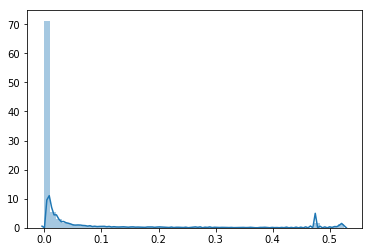

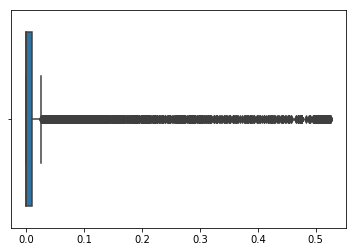

In [121]:
print(stats.describe(fr_losses))
print(np.median(fr_losses))
sns.distplot(fr_losses)
plt.show()
sns.boxplot(fr_losses)
plt.show()

In [132]:
losses = np.array(losses)
losses[losses>0.0007677971152588725].shape[0] * 100 / losses.shape[0]

0.9103445844749951

DescribeResult(nobs=6354407, minmax=(1.6191663689824054e-06, 0.48562535643577576), mean=6.333383326033283e-05, variance=4.012616742448437e-07, skewness=200.32650262997396, kurtosis=84081.4986867353)
1.540284756629262e-05


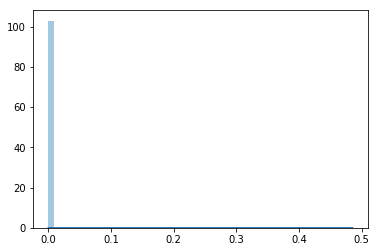

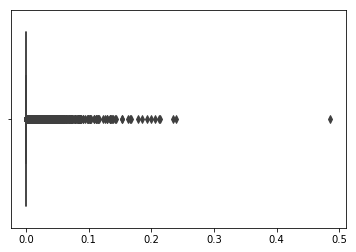

In [123]:
print(stats.describe(losses))
# print(stats.mode(losses))
print(np.median(losses))
sns.distplot(losses)
plt.show()
sns.boxplot(losses)
plt.show()